# 4 - Treinamento de modelos

Nessa fase, treinaremos os modelos classificadores candidatos. 

Nessa etapa o problema se torna semelhante aos modelos de ML tradicionais: testaremos diversos classificadores como *RandomForest*, *AdaBoost*, entre outros, e otimizaremos também os hiperparâmetros do modelo com técnicas como a *GridSearch* e a *RandomizedSearch*.

In [1]:
# caminho para instalação do pacote mltoolkit, com metricas e gráficos personalizados
# !pip install git+ssh://git@github.com/flimao/mltoolkit

In [2]:
import pandas as pd
import numpy as np
from matplotlib import rcParams, rcParamsDefault, pyplot as plt
import seaborn as sns
from mltoolkit import metrics, plots, NLP
import spacy
from tqdm import tqdm

rcParams.update(rcParamsDefault)
rcParams['figure.dpi'] = 120
rcParams['figure.figsize'] = (10, 8)

tqdm.pandas()

In [3]:
# !python -m spacy download pt_core_news_lg
# !python -m spacy download pt_core_news_md
# !python -m spacy download pt_core_news_sm
nlp = spacy.load("pt_core_news_lg")

## Importação dos dados

Primeiramente, importamos os dados e aplicamos as transformações utilizadas na fase anterior:

In [4]:
# não tocaremos no conjunto de submissão

tweets_raw = pd.read_csv(
    r'../data/Train3Classes.csv',
)

In [5]:
# trocar tipos para acelerar o processamento (menos espaço em memória)
# e ativar possíveis otimizações internas ao pandas para certos tipos
def mudar_tipos(df):
    df = df.copy()

    df['id'] = df['id'].astype('string')
    df['tweet_date'] = pd.to_datetime(df['tweet_date'])
    df['sentiment'] = df['sentiment'].astype('category')

    return df

def remover_duplicatas(df):
    df = df.copy()

    df = df.drop_duplicates(subset = 'id')

    return df

# o índice é o id, visto que não há repetidos
# vantagem: o índice é removido automaticamente quando separamos em base de treino e teste.
def setar_index(df):
    df = df.copy()

    df = df.set_index('id')

    return df

tweets_full = (tweets_raw
    .pipe(mudar_tipos)
    .pipe(remover_duplicatas)
    .pipe(setar_index)
)

## Pré-processamento de texto

Vamos então implementar o pré-processamento do texto da fase anterior (Análise Exploratória de Texto).

Primeiramente vamos importar as *stopwords*:

In [6]:
with open(r'../data/stopwords_alopes.txt', encoding = 'utf8') as stopword_list:
    lst = stopword_list.read().splitlines()

stopwords_alopes = set([ stopword.strip() for stopword in lst ])

# em uma análise de sentimento, não queremos remover palavras com conotação negativa
remover_stopwords = {
    'não', 
}

stopwords_alopes -= remover_stopwords

In [7]:
preprocessing_full = lambda s: NLP.preprocessing(s, preproc_funs_args = [
    NLP.remove_links,
    NLP.remove_hashtags,
    NLP.remove_mentions,
    NLP.remove_numbers,
    NLP.remove_special_caract,
    NLP.lowercase,
    #remove_punkt,
    #(remove_stopwords, dict(stopword_list = stopword_list_alopes)),
    (NLP.tokenize_remove_stopwords_get_radicals_spacy, dict(
        nlp = nlp,
        stopword_list = stopwords_alopes,
    )),
])

Vamos então aplicar esse pré-processamento a uma amostra da base de *tweets* (para podermos iterar rapidamente caso necessário). 

Em um momento posterior, treinaremos a base completa.

In [8]:
amostra_eda = 5000
radicais = tweets_full.sample(amostra_eda)['tweet_text'].progress_apply(preprocessing_full)

tweets = tweets_full.copy()
tweets['radicais'] = radicais
tweets = tweets[tweets.radicais.notna()]

100%|██████████| 5000/5000 [00:41<00:00, 119.27it/s]


In [87]:
tweets.sample(10)

,tweet_text,tweet_date,sentiment,query_used,radicais
id,,,,,
1047035308938792968,@bybaekbyun @ahniyxd apa c qmo :(,2018-10-02 08:07:25+00:00,0,:(,apa c qmo
1049165592886796288,@AnnaPaolaOrtega Felicidades!! :),2018-10-08 05:12:24+00:00,1,:),felicidade
1043950366906298369,Surfistas homenageiam brasileiro morto por tub...,2018-09-23 19:48:57+00:00,2,g1,surfista homenagear brasileiro morto tubarao eua
1046239935949406208,@jccguk ele oarece uma criancinha ne :( meu be...,2018-09-30 03:26:53+00:00,0,:(,oarece criança ne bebé ai to muiro triste ana ...
1046761233750339584,"@angelaalacchi Nada, a mandar. :))",2018-10-01 13:58:20+00:00,1,:),mandar
1046269541175742464,"@RafaeIVB Isso! Uhuuul,vamos votar tudo no Had...",2018-09-30 05:24:32+00:00,1,:),uhuuul ir votar haddad brasil ir pra puta parir d
1045499441875222528,a bruna já virou jikooka falta ela entrar pra ...,2018-09-28 02:24:26+00:00,1,:),bruno ja virar jikooka entrar pra fandom to
1046749860500652033,gente você acredita que um dia vai ser amada t...,2018-10-01 13:13:09+00:00,0,:(,gente voce acreditar dia amar totalmente pesso...
1046923727110377472,Nossa o hyuck n é? :( https://t.co/HBfS3CZoRb,2018-10-02 00:44:02+00:00,0,:(,hyuck n


## Treinamento de modelos

Vamos agora testar vários modelos de aprendizado de máquina, comparando-os para escolher o melhor.

### Preparação

In [11]:
X = tweets['radicais'] + ' ' + tweets['query_used'] # conforme dito na fase de Análise Exploratória
y = tweets['sentiment']

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.3,
    stratify = y
)

### Definição do *pipeline*

Vamos montar um *pipeline* de processamento do `scikit-learn`. Dessa forma, podemos automatizar o processo de otimização de hiperparâmetros após a escolha do melhor modelo.

Um *pipeline* é composto de um ou mais *transformers* e um estimador ao final. Os *transformers* tem como função transformar os dados, de forma que eles possam ser usados como entrada para um estimador, que usará os dados para fazer estimativas.

No nosso caso, a nossa *pipeline* será composta de um *transformer* e um estimador, detalhados a seguir.

#### Definição dos *Transformers*

No nosso caso, os *transformers* terão como *input* os *tweets* já pré-processados (mas ainda em formato de texto), e terão como saída uma série de *features* numéricas.

Testaremos 4 *transformers* diferentes:

In [13]:
pipeline_transformers = {}

##### ***Bag of Words* (`CountVectorizer`)**

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer()

pipeline_transformers['bow'] = bow

##### ***Bag of Words* - TF-IDF**

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(use_idf=True)

pipeline_transformers['tfidf'] = tfidf

##### ***Word2Vec***

In [21]:
from mltoolkit.NLP import W2VTransformer

word2vec = W2VTransformer(
    vector_size = 50,
    min_count = 2,
    workers = 2
)

pipeline_transformers['word2vec'] = word2vec

##### ***Doc2Vec***

In [22]:
from mltoolkit.NLP import D2VTransformer

doc2vec = D2VTransformer(
    vector_size = 50,
    min_count = 2,
    workers = 2
)

pipeline_transformers['doc2vec'] = doc2vec

#### Definição dos estimadores

Os estimadores são os diferentes modelos de aprendizado de máquina, que utilizaremos para predizer o tom (sentimento) de um *tweet* qualquer.

In [28]:
from copy import deepcopy

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

# para reproducibilidade
random_seed = 42

pipeline_estimadores = {
    'logistic': LogisticRegression(random_state = random_seed),
    'random_forest': RandomForestClassifier(random_state = random_seed),
    'adaboost': AdaBoostClassifier(random_state = random_seed),
    'xgboost': XGBClassifier(random_state = random_seed, eval_metric = 'logloss'),
}

#### Preparação do *pipeline*

Vamos agora cruzar cada *transformer* com cada estimador, e rodar os *pipelines* resultantes.

In [35]:
from sklearn.pipeline import Pipeline

pipelines = {}

# construindo as pipelines
for nome_transformer, transformer in pipeline_transformers.items():
    for nome_estimador, estimador in pipeline_estimadores.items():
        pipelines[f'{nome_estimador}.{nome_transformer}'] = Pipeline(steps = [
            (nome_transformer, deepcopy(transformer)),
            (nome_estimador, deepcopy(estimador))
        ])

In [36]:
# rodando as pipelines
for nome_pipeline, pipeline in tqdm(pipelines.items(), desc = 'Pipeline'):
    nome_estimador, nome_transformer = nome_pipeline.split('.')
    pipeline.fit(X_train, y_train)

Pipeline: 100%|██████████| 16/16 [00:31<00:00,  1.95s/it]


In [37]:
print(nome_pipeline)

xgboost.doc2vec


In [40]:
# vamos ver se funcionou...
from sklearn.metrics import classification_report

est = pipelines['random_forest.tfidf']

y_pred = est.predict(X_test)

print(classification_report(
    y_true = y_test,
    y_pred = y_pred
))

              precision    recall  f1-score   support

           0       0.65      0.65      0.65       494
           1       0.66      0.64      0.65       514
           2       0.96      0.99      0.98       492

    accuracy                           0.76      1500
   macro avg       0.76      0.76      0.76      1500
weighted avg       0.75      0.76      0.76      1500



## Medição de desempenho

Vamos agora ver como o desempenho de cada combinação de modelo com *transformer* se compara com os demais.

In [68]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# construindo um dataframe com as métricas relevantes

model_rank_name = pd.Series(pipelines.keys()).str.split('.')
model_rank_name = pd.DataFrame(model_rank_name.to_list(), columns = ['estimador', 'transformer'])
model_rank_idx = pd.MultiIndex.from_frame(model_rank_name)

model_rank = pd.DataFrame([], index = model_rank_idx)

for nome_pipeline, pipeline in tqdm(pipelines.items(), desc = 'Medindo desempenho'):
    nome_estimador, nome_transformer = nome_pipeline.split('.')

    # gerando a predição
    y_pred = pipeline.predict(X_test)
    
    # dicionário com argumentos de todas as funções
    kwargs = dict(y_true = y_test, y_pred = y_pred)

    # calculando as métricas
    acc = accuracy_score(**kwargs)
    precision = precision_score(average = 'weighted', **kwargs)
    recall = recall_score(average = 'weighted', **kwargs)
    f1 = f1_score(average = 'weighted', **kwargs)

    # registrando as métricas no dataframe
    model_rank.loc[(nome_estimador, nome_transformer), 'accuracy'] = acc
    model_rank.loc[(nome_estimador, nome_transformer), 'precision'] = precision
    model_rank.loc[(nome_estimador, nome_transformer), 'recall'] = recall
    model_rank.loc[(nome_estimador, nome_transformer), 'f1'] = f1

model_rank.sort_values(by = ['f1', 'accuracy'], ascending = False, inplace = True)

Medindo desempenho: 100%|██████████| 16/16 [00:03<00:00,  4.47it/s]


In [71]:
with pd.option_context('display.float_format', lambda x: f'{x:.2%}'):
    display(model_rank)

accuracy  precision  recall     f1
estimador     transformer                                    
logistic      word2vec       95.27%     95.35%  95.27% 95.25%
random_forest word2vec       85.27%     85.53%  85.27% 85.26%
xgboost       word2vec       84.67%     84.79%  84.67% 84.65%
logistic      bow            78.33%     78.27%  78.33% 78.30%
xgboost       bow            78.13%     78.27%  78.13% 77.95%
logistic      tfidf          77.80%     77.80%  77.80% 77.76%
xgboost       tfidf          77.80%     77.94%  77.80% 77.66%
random_forest tfidf          75.80%     75.49%  75.80% 75.63%
              bow            75.13%     74.95%  75.13% 74.86%
adaboost      bow            67.27%     70.85%  67.27% 61.15%
              word2vec       59.40%     59.09%  59.40% 58.86%
              tfidf          61.00%     60.36%  61.00% 56.57%
              doc2vec        46.60%     46.05%  46.60% 45.29%
random_forest doc2vec        46.53%     45.38%  46.53% 44.82%
xgboost       doc2vec        44.87%     44.34%  44.87% 44.33%
logistic      doc2vec        42.87%     41.77%  42.87% 41.09%

Parece que 
* o *transformer* ***Word2Vec*** performa muito bem nessa base: as três melhores combinações usam esse *transformer*; e
* especificamente, **o modelo de regressão logística com *transformer* *Word2Vec* performou de forma excelente** no conjunto de teste.

In [80]:
nome_pipeline = 'logistic.word2vec'
nome_estimador, nome_transformer = nome_pipeline.split('.')
est = pipelines[nome_pipeline]

y_pred = est.predict(X_test)

print(f"Modelo '{nome_estimador}', transformer '{nome_transformer}':")
print(classification_report(
    y_true = y_test,
    y_pred = y_pred
))

Modelo 'logistic', transformer 'word2vec':
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       494
           1       0.94      0.98      0.96       514
           2       0.98      0.91      0.94       492

    accuracy                           0.95      1500
   macro avg       0.95      0.95      0.95      1500
weighted avg       0.95      0.95      0.95      1500



Modelo 'logistic', transformer 'word2vec':


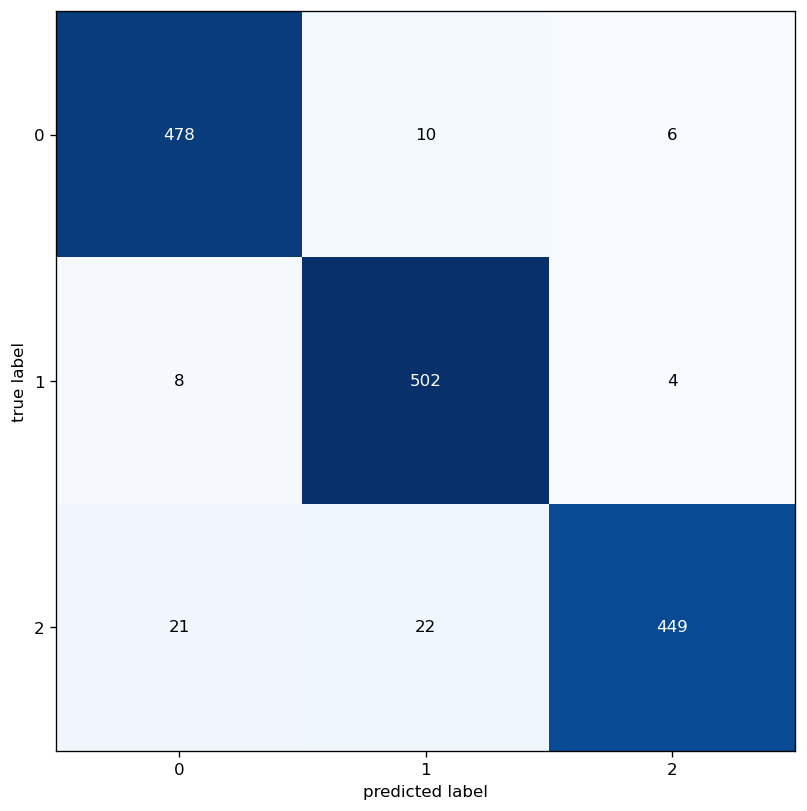

In [81]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(f"Modelo '{nome_estimador}', transformer '{nome_transformer}':")
plot_confusion_matrix(conf_mat=cm)
plt.show()

Aparentemente o modelo tem uma leve dificuldade em prever *tweets* de tom neutro. No entanto, mesmo nesse caso, **o *recall* para esta classe é superior a 90%**, corroborando o desempenho excelente.

Outros modelos que performaram muito bem foram **o estimador de *Random Forest* com *transformer* *Word2Vec***....

In [82]:
nome_pipeline = 'random_forest.word2vec'
nome_estimador, nome_transformer = nome_pipeline.split('.')
est = pipelines[nome_pipeline]

y_pred = est.predict(X_test)

print(f"Modelo '{nome_estimador}', transformer '{nome_transformer}':")
print(classification_report(
    y_true = y_test,
    y_pred = y_pred
))

Modelo 'random_forest', transformer 'word2vec':
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       494
           1       0.81      0.90      0.85       514
           2       0.87      0.84      0.85       492

    accuracy                           0.85      1500
   macro avg       0.86      0.85      0.85      1500
weighted avg       0.86      0.85      0.85      1500



Modelo 'random_forest', transformer 'word2vec':


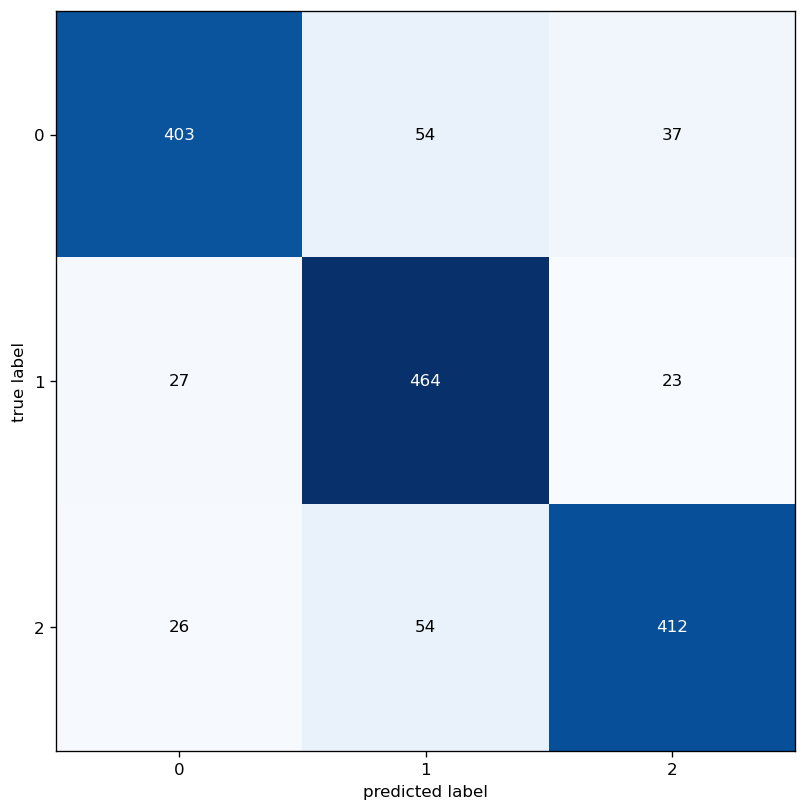

In [83]:
cm = confusion_matrix(y_test, y_pred)

print(f"Modelo '{nome_estimador}', transformer '{nome_transformer}':")
plot_confusion_matrix(conf_mat=cm)
plt.show()

... e o estimador ***XGBoost*, também com *transformer* *Word2Vec***:

In [84]:
nome_pipeline = 'xgboost.word2vec'
nome_estimador, nome_transformer = nome_pipeline.split('.')
est = pipelines[nome_pipeline]

y_pred = est.predict(X_test)

print(f"Modelo '{nome_estimador}', transformer '{nome_transformer}':")
print(classification_report(
    y_true = y_test,
    y_pred = y_pred
))

Modelo 'xgboost', transformer 'word2vec':
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       494
           1       0.82      0.89      0.85       514
           2       0.87      0.82      0.84       492

    accuracy                           0.85      1500
   macro avg       0.85      0.85      0.85      1500
weighted avg       0.85      0.85      0.85      1500



Modelo 'xgboost', transformer 'word2vec':


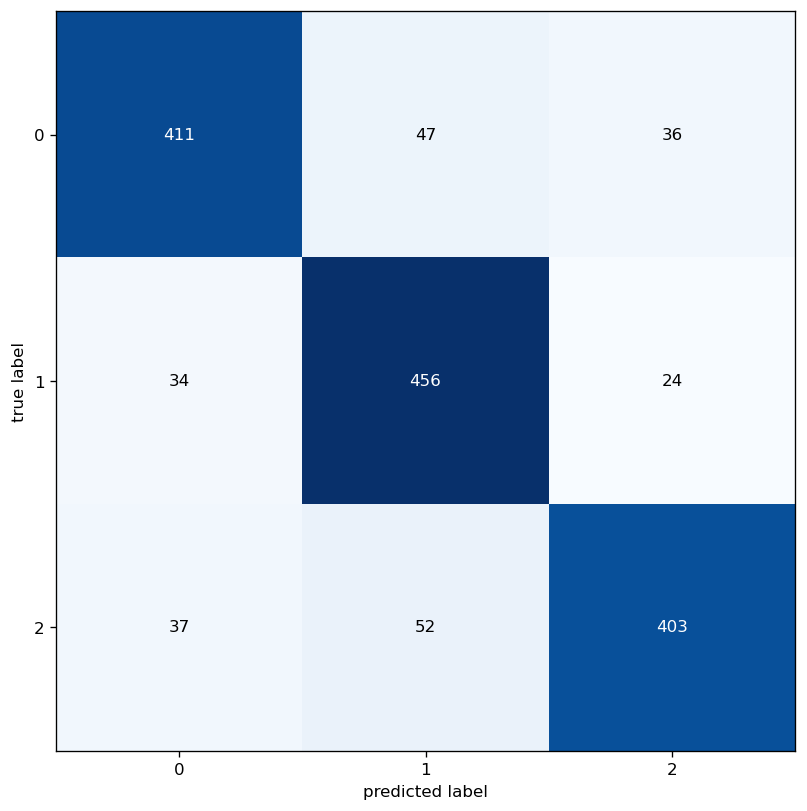

In [85]:
cm = confusion_matrix(y_test, y_pred)

print(f"Modelo '{nome_estimador}', transformer '{nome_transformer}':")
plot_confusion_matrix(conf_mat=cm)
plt.show()

Ainda que os estimadores *XGBoost* e *Random Forest* tenham performado muito bem, a performance da Regressão Logística foi incomparável em todas as métricas.

Vamos portanto prroseguir com a otimização desse modelo.

## Otimização do modelo de **Regressão Logística** com *transformer* ***Word2vec***.

Vamos otimizar agora o modelo fitado. Para tal, precisamos alterar seus hiperparâmetros e checar se o ajuste é melhor.

Para tal, primeiramente vamos definir quais hiperparâmetros vamos testar e com quais valores.

In [88]:
# definimos parâmetros de vários estimadores e transformers caso precisemos

otimizacoes = dict(
    tfidf = dict(
        use_idf = [True, False],
    ),
    word2vec = dict(
        vector_size = [10, 50, 100, 200],
        vector_combination = [
            lambda x: np.sum(x, axis = 0),
            lambda x: np.mean(x, axis = 0)
        ],
    ),
    doc2vec = dict(
        vector_size = [10, 50, 100, 200],
    ),
    logistic = {
        'penalty': ['elasticnet', 'l1', 'l2'],
        'fit_intercept': [True, False],
        'solver': [ 'lbfgs', 'saga' ],
    },
    xgboost = {
        'criterion': ['friedman_mse', 'mae' ],
        'max_features': [ 'log2', 'sqrt' ],
        'learning_rate': [ 0.01, 0.05, 0.1, 0.5, 1, ],
        'max_depth': [ 3, 4, 5, 10 ],
        'n_estimators': [ 5 ,10, 15, 20, 100, 150 ],
    },
    random_forest = {
        'n_estimators': [200, 500],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth' : [4,5,6,7,8],
        'criterion' :['gini', 'entropy']
    },
)

Vamos agora configurar a otimização:

In [97]:
from pprint import pprint

# para cada nome de modelo a ser otimizado, haverá um dicionário com a configuração da otimização

nomes_modelos = [ 'logistic.word2vec', 'random_forest.word2vec' ]

params = {}

for nome in nomes_modelos:
    params[nome] = {}
    for nome_pipe in nome.split('.'):
        for nome_param, valores_param in otimizacoes.get(nome_pipe, {}).items():
            params[nome][f'{nome_pipe}__{nome_param}'] = valores_param
    
    if not params[nome]:
        _ = params.pop(nome, None)

pprint(params)

{'logistic.word2vec': {'logistic__fit_intercept': [True, False],
                       'logistic__penalty': ['elasticnet', 'l1', 'l2'],
                       'logistic__solver': ['lbfgs', 'saga'],
                       'word2vec__vector_combination': [<function <lambda> at 0x000001B1A4096DC0>,
                                                        <function <lambda> at 0x000001B1A439A040>],
                       'word2vec__vector_size': [10, 50, 100, 200]},
 'random_forest.word2vec': {'random_forest__criterion': ['gini', 'entropy'],
                            'random_forest__max_depth': [4, 5, 6, 7, 8],
                            'random_forest__max_features': ['auto',
                                                            'sqrt',
                                                            'log2'],
                            'random_forest__n_estimators': [200, 500],
                            'word2vec__vector_combination': [<function <lambda> at 0x000001B1A4096DC0>,
   

In [99]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from datetime import datetime as dt

nome_score = 'accuracy'
searchers = {}

cv = StratifiedKFold(
    n_splits = 3,
)

# deletar a variável t0 caso exista, para que a lógica de timing dos testes não se confunda
try:
    del t0
except NameError:
    pass

print('Iniciando busca...')
for nome_pipeline, hiperparams_otim in params.items():

    nome_estimador, nome_transformer = nome_pipeline.split('.')
    modelo = pipelines[nome_pipeline]
    
    try:
        tfim = dt.now()
        delta = tfim - t0
        print(f"... OK. (Duração da busca: {delta})\n")
    except NameError:   # variavel t0 não existe: primeira iteração do loop
        pass

    print(f"Procurando hiperparâmetros ótimos para o modelo '{nome_estimador}' com transformer '{nome_transformer}'... ")
    t0 = dt.now()
    random_search = RandomizedSearchCV(
        estimator = modelo, 
        param_distributions = hiperparams_otim, 
        scoring = nome_score,
        n_iter = 150,
        cv = cv, 
        verbose = 2,
        n_jobs = -1,
    )
    
    searchers[nome_pipeline] = random_search.fit(X_train, y_train)

tfim = dt.now()
delta = tfim - t0
print(f"... OK. (Duração da busca: {delta})")


Iniciando busca...
Procurando hiperparâmetros ótimos para o modelo 'logistic' com transformer 'word2vec'... 
Fitting 3 folds for each of 96 candidates, totalling 288 fits
... OK. Duração da busca: 0:01:28.283066)

Procurando hiperparâmetros ótimos para o modelo 'random_forest' com transformer 'word2vec'... 
Fitting 3 folds for each of 150 candidates, totalling 450 fits
... OK. Duração da busca: 0:08:59.878244


In [100]:
for nome_pipeline, searcher in searchers.items():
    nome_estimador, nome_transformer = nome_pipeline.split('.')
    print(f"Melhores parâmetros para o modelo '{nome_estimador}' com transformer '{nome_transformer}':")
    pprint(searcher.best_params_)
    print('')

Melhores parâmetros para o modelo 'logistic' com transformer 'word2vec':
{'logistic__fit_intercept': True,
 'logistic__penalty': 'l2',
 'logistic__solver': 'lbfgs',
 'word2vec__vector_combination': <function <lambda> at 0x000001B1A4096DC0>,
 'word2vec__vector_size': 100}

Melhores parâmetros para o modelo 'random_forest' com transformer 'word2vec':
{'random_forest__criterion': 'entropy',
 'random_forest__max_depth': 8,
 'random_forest__max_features': 'sqrt',
 'random_forest__n_estimators': 200,
 'word2vec__vector_combination': <function <lambda> at 0x000001B1A439A040>,
 'word2vec__vector_size': 200}



A melhora no desempenho de cada um dos modelos é:

In [101]:
cvresults = {}

for nome_modelo, searcher in searchers.items():
    rsdf = pd.DataFrame(searcher.cv_results_)
    rsdf = rsdf.set_index([ col for col in rsdf.columns if col.startswith('param_') ])
    cvresults[nome_modelo] = rsdf.sort_values(by = 'rank_test_score')

In [104]:
cvresults['logistic.word2vec']

mean_fit_time  \
param_word2vec__vector_size param_word2vec__vector_combination        param_logistic__solver param_logistic__penalty param_logistic__fit_intercept                  
100                         <function <lambda> at 0x000001B1A4096DC0> lbfgs                  l2                      True                                1.467803   
50                          <function <lambda> at 0x000001B1A4096DC0> lbfgs                  l2                      True                                1.364848   
100                         <function <lambda> at 0x000001B1A4096DC0> lbfgs                  l2                      False                               1.016911   
200                         <function <lambda> at 0x000001B1A4096DC0> lbfgs                  l2                      True                                1.321234   
                                                                                                                     False                               1.049683   
...                                                                                                                                                           ...   
100                         <function <lambda> at 0x000001B1A4096DC0> lbfgs                  l1                      False                               0.708119   
200                         <function <lambda> at 0x000001B1A4096DC0> lbfgs                  l1                      False                               0.791348   
10                          <function <lambda> at 0x000001B1A439A040> lbfgs                  l1                      False                               0.720864   
100                         <function <lambda> at 0x000001B1A439A040> lbfgs                  l1                      False                               0.834265   
10                          <function <lambda> at 0x000001B1A4096DC0> lbfgs                  elasticnet              True                                1.123850   

                                                                                                                                                    std_fit_time  \
param_word2vec__vector_size param_word2vec__vector_combination        param_logistic__solver param_logistic__penalty param_logistic__fit_intercept                 
100                         <function <lambda> at 0x000001B1A4096DC0> lbfgs                  l2                      True                               0.204379   
50                          <function <lambda> at 0x000001B1A4096DC0> lbfgs                  l2                      True                               0.184227   
100                         <function <lambda> at 0x000001B1A4096DC0> lbfgs                  l2                      False                              0.028079   
200                         <function <lambda> at 0x000001B1A4096DC0> lbfgs                  l2                      True                               0.148747   
                                                                                                                     False                              0.056142   
...                                                                                                                                                          ...   
100                         <function <lambda> at 0x000001B1A4096DC0> lbfgs                  l1                      False                              0.032345   
200                         <function <lambda> at 0x000001B1A4096DC0> lbfgs                  l1                      False                              0.041782   
10                          <function <lambda> at 0x000001B1A439A040> lbfgs                  l1                      False                              0.053195   
100                         <function <lambda> at 0x000001B1A439A040> lbfgs                  l1                      False                              0.022445   
10                          <funct

In [105]:
from sklearn.metrics import SCORERS

fscore = SCORERS[nome_score]

print(f"Usando score = '{nome_score}'\n")

best_scores = { nome_modelo: searcher.best_score_ for nome_modelo, seacher in searchers.items() }

for nome_modelo in nomes_modelos:
    nome_estimador, nome_transformer = nome_modelo.split('.')
    modelo = pipelines[nome_pipeline]

    print(f"Resultados para modelo '{nome_estimador}' com transformer '{nome_transformer}':")
    score_original = fscore(
        estimator = pipelines[nome_modelo],
        X = X_test,
        y_true = y_test,
    )
    score_otimizado = cvresults[nome_modelo].iloc[0]['mean_test_score']

    if nome_score.startswith('neg'):
        melhoria = score_original / score_otimizado - 1
    else:
        melhoria = score_otimizado / score_original - 1

    frase_score_orig = f"Score '{nome_score}' original"
    frase_score_opt = f"Score '{nome_score}' otimizado"
    frase_melhoria = 'Melhoria'

    ncaract = len(frase_score_opt) + 4

    print(f"{frase_score_orig:>{ncaract}s}: {score_original:}")
    print(f"{frase_score_opt:>{ncaract}s}: {score_otimizado:}")
    print(f"{frase_melhoria:>{ncaract}s}: {melhoria:.3%}")
    print('')


Usando score = 'accuracy'

Resultados para modelo 'logistic' com transformer 'word2vec':
     Score 'accuracy' original: 0.9526666666666667
    Score 'accuracy' otimizado: 0.9674268513333363
                      Melhoria: 1.549%

Resultados para modelo 'random_forest' com transformer 'word2vec':
     Score 'accuracy' original: 0.8526666666666667
    Score 'accuracy' otimizado: 0.8957168816750715
                      Melhoria: 5.049%

